# Final Project Zillow Data with Crime Statistics

Data wraningling and analysis on zillow housing data and FBI crime statistics from across the country.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%pylab inline

import sklearn as sk
import sklearn.tree as tree
from IPython.display import Image  
import pydotplus

Populating the interactive namespace from numpy and matplotlib


## Load Home Values for all U.S. cities

In [62]:
city = pd.read_csv('City_time_series.csv')

In [63]:
city_names = pd.read_csv('cities_crosswalk.csv')

In [64]:
city = city_names.merge(city, left_on = 'Unique_City_ID', right_on='RegionName', how = 'right')

In [65]:
city['Year'] = city['Date'].apply(lambda x:x[:4])

In [66]:
city.drop(['RegionName','Unique_City_ID','Date','County'], axis = 1, inplace = True)

Take only 2014-2016 to merge because crime data is only from 2014-2016

In [67]:
city14_16 = city[(city.Year =='2016')|(city.Year =='2015')|(city.Year=='2014')]

In [68]:
city14_16.head()

,City,State,InventorySeasonallyAdjusted_AllHomes,InventoryRaw_AllHomes,MedianListingPricePerSqft_1Bedroom,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom,MedianListingPricePerSqft_5BedroomOrMore,MedianListingPricePerSqft_AllHomes,...,ZHVI_CondoCoop,ZHVI_MiddleTier,ZHVI_SingleFamilyResidence,ZHVI_TopTier,ZRI_AllHomes,ZRI_AllHomesPlusMultifamily,ZriPerSqft_AllHomes,Zri_MultiFamilyResidenceRental,Zri_SingleFamilyResidenceRental,Year
213,Oak Grove,KY,119.0,119.0,NaN,NaN,87.412587,NaN,NaN,81.751055,...,NaN,92600.0,92600.0,115900.0,819.0,792.0,0.754,683.0,795.0,2014
214,Oak Grove,KY,108.0,100.0,NaN,NaN,85.374332,NaN,NaN,81.818182,...,NaN,92600.0,92600.0,115600.0,821.0,796.0,0.756,684.0,799.0,2014
215,Oak Grove,KY,105.0,98.0,NaN,NaN,88.211181,NaN,NaN,84.552846,...,NaN,92900.0,92900.0,115200.0,823.0,798.0,0.760,685.0,801.0,2014
216,Oak Grove,KY,105.0,99.0,NaN,NaN,87.029289,NaN,NaN,84.747465,...,NaN,93400.0,93400.0,115200.0,824.0,801.0,0.760,686.0,804.0,2014
217,Oak Grove,KY,102.0,100.0,NaN,NaN,84.356542,NaN,NaN,84.510669,...,NaN,93600.0,93600.0,115300.0,827.0,803.0,0.762,689.0,807.0,2014


Each row is currently a single month of data for a city, but we need it to be aggregated by year to match up with the crime data which only has yearly totals per city. So we will group by city, state, and year then take mean values.

In [69]:
city14_16 = city14_16.groupby(['City','State','Year']).mean().reset_index()

Extra cleaning on 'City' column to ensure proper merging with the crime data below.

In [70]:
city14_16['City'] = city14_16['City'].apply(lambda x:x.replace('Township',''))
city14_16['City'] = city14_16['City'].apply(lambda x:x.rstrip(' '))

## Load Crime Data

In [71]:
crime = pd.read_csv('crime14-16.csv')

In [72]:
crime['Year'] = crime['Year'].astype(str)

In [75]:
crime.head()

,State,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson,Year
0,AL,Abbeville,"2,643",8,0,1,NaN,0,7,85,22,52,11,NaN,2014
1,AL,Adamsville,"4,430",30,0,5,NaN,6,19,373,43,321,9,NaN,2014
2,AL,Addison,747,1,0,0,NaN,0,1,31,6,22,3,NaN,2014
3,AL,Alabaster,"31,568",58,1,9,NaN,11,37,612,68,526,18,NaN,2014
4,AL,Albertville,"21,655",23,1,5,NaN,8,9,756,230,454,72,NaN,2014


Some cities in the data are labeled "'city name', 'County name'". This function drops the 'County name' and ',' for those cities that have it.

In [73]:
def county_drop(x):
    if 'County' in x:
        y = x.rsplit(None, 2)[0]
        return y.rstrip(', ')
    else:
        return x

In [74]:
crime['City'] = crime['City'].apply(lambda x:x.rstrip('0123456789'))
crime['City'] = crime['City'].apply(county_drop)
crime['City'] = crime['City'].apply(lambda x:x.replace('Township',''))
crime['City'] = crime['City'].apply(lambda x:x.rstrip(' '))

Because of the inconsistencies when reporting rape, we chose to drop those columns.

In [77]:
crime.drop(['Rape\n(revised\ndefinition)1','Rape\n(legacy\ndefinition)2'], axis = 1, inplace = True)

We need cities with non zero population values because we will divide the number of crimes by population to get crime rates.

In [78]:
crime = crime[(crime.Population.notnull()) & (crime.Population != '0')]

In [80]:
crime.fillna(0, inplace = True)

Rename columns

In [81]:
crime.columns = ['State', 'City', 'Population', 'Violent_crime','Murder','Robbery','Aggravated_assault',
               'Property_crime','Burglary','Larceny_theft', 'Vehicle_theft', 'Arson', 'Year']

Convert certain columns to numeric

In [82]:
crime['Population'] = crime['Population'].apply(lambda x: x.replace(',','')).apply(pd.to_numeric)
crime['Violent_crime'] = crime['Violent_crime'].astype(str).apply(lambda x: x.replace(',','')).apply(pd.to_numeric)
crime['Murder'] = crime['Murder'].astype(str).apply(lambda x: x.replace(',','')).apply(pd.to_numeric)
crime['Robbery'] = crime['Robbery'].astype(str).apply(lambda x: x.replace(',','')).apply(pd.to_numeric)
crime['Aggravated_assault'] = crime['Aggravated_assault'].astype(str).apply(lambda x: x.replace(',','')).apply(pd.to_numeric)
crime['Property_crime'] = crime['Property_crime'].astype(str).apply(lambda x: x.replace(',','')).apply(pd.to_numeric)
crime['Burglary'] = crime['Burglary'].astype(str).apply(lambda x: x.replace(',','')).apply(pd.to_numeric)
crime['Larceny_theft'] = crime['Larceny_theft'].astype(str).apply(lambda x: x.replace(',','')).apply(pd.to_numeric)
crime['Vehicle_theft'] = crime['Vehicle_theft'].astype(str).apply(lambda x: x.replace(',','')).apply(pd.to_numeric)
crime['Arson'] = crime['Arson'].astype(str).apply(lambda x: x.replace(',','')).apply(pd.to_numeric)

Add columns for rate of crime per 10,000 people

In [83]:
crime['Violent_crime_rate'] = (crime['Violent_crime']/crime.Population)*10000
crime['Murder_rate'] = (crime['Murder']/crime.Population)*10000
crime['Robbery_rate'] = (crime['Robbery']/crime.Population)*10000
crime['Aggravated_assault_rate'] = (crime['Aggravated_assault']/crime.Population)*10000
crime['Property_crime_rate'] = (crime['Property_crime']/crime.Population)*10000
crime['Burglary_rate'] = (crime['Burglary']/crime.Population)*10000
crime['Larceny_theft_rate'] = (crime['Larceny_theft']/crime.Population)*10000
crime['Vehicle_theft_rate'] = (crime['Vehicle_theft']/crime.Population)*10000
crime['Arson_rate'] = (crime['Arson']/crime.Population)*10000

We want to find the average crime rate for each state and add that as a new column to each row of city data. We will then be able to compare if a city has more or less crime than the average crime for the state in which that city resides.

In [84]:
crime['avg_crime'] = crime[['Violent_crime_rate', 'Property_crime_rate']].mean(axis=1)

In [85]:
state_avg_crime = crime.groupby(['State','Year'])['avg_crime'].mean().reset_index().rename(columns={
        'avg_crime':'State_avg_crime_rate'})

In [88]:
state_avg_crime.head()

,State,Year,State_avg_crime_rate
0,AK,2014,165.400571
1,AK,2015,168.146621
2,AK,2016,177.270966
3,AL,2014,209.042392
4,AL,2015,203.809278


In [86]:
crime = crime.merge(state_avg_crime, right_on = ['State','Year'],left_on = ['State','Year'], how = 'left')

In [87]:
crime['above_avg_crime'] = (crime.avg_crime>crime.State_avg_crime_rate)*1.0

In [89]:
crime.head()

,State,City,Population,Violent_crime,Murder,Robbery,Aggravated_assault,Property_crime,Burglary,Larceny_theft,...,Robbery_rate,Aggravated_assault_rate,Property_crime_rate,Burglary_rate,Larceny_theft_rate,Vehicle_theft_rate,Arson_rate,avg_crime,State_avg_crime_rate,above_avg_crime
0,AL,Abbeville,2643,8,0,0,7,85,22,52,...,0.000000,26.485055,321.604238,83.238744,196.746122,41.619372,0.0,175.936436,209.042392,0.0
1,AL,Adamsville,4430,30,0,6,19,373,43,321,...,13.544018,42.889391,841.986456,97.065463,724.604966,20.316027,0.0,454.853273,209.042392,1.0
2,AL,Addison,747,1,0,0,1,31,6,22,...,0.000000,13.386881,414.993307,80.321285,294.511379,40.160643,0.0,214.190094,209.042392,1.0
3,AL,Alabaster,31568,58,1,11,37,612,68,526,...,3.484541,11.720730,193.867207,21.540801,166.624430,5.701977,0.0,106.120122,209.042392,0.0
4,AL,Albertville,21655,23,1,8,9,756,230,454,...,3.694297,4.156084,349.111060,106.211037,209.651351,33.248672,0.0,179.866082,209.042392,0.0


## Merge Crime with Real Estate Data

In [95]:
city_with_crime = city14_16.merge(crime, left_on = ['City','State','Year'], right_on = ['City','State','Year'], how = 'right')

In [96]:
city_with_crime.head()

,City,State,Year,InventorySeasonallyAdjusted_AllHomes,InventoryRaw_AllHomes,MedianListingPricePerSqft_1Bedroom,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom,MedianListingPricePerSqft_5BedroomOrMore,...,Robbery_rate,Aggravated_assault_rate,Property_crime_rate,Burglary_rate,Larceny_theft_rate,Vehicle_theft_rate,Arson_rate,avg_crime,State_avg_crime_rate,above_avg_crime
0,Abbeville,AL,2014,97.416667,97.333333,NaN,NaN,NaN,NaN,NaN,...,0.000000,26.485055,321.604238,83.238744,196.746122,41.619372,0.00000,175.936436,209.042392,0.0
1,Abbeville,AL,2015,107.416667,107.416667,NaN,NaN,106.239666,NaN,NaN,...,0.000000,22.988506,291.187739,91.954023,191.570881,7.662835,0.00000,162.835249,203.809278,0.0
2,Abbeville,AL,2016,108.666667,108.833333,NaN,NaN,106.948524,NaN,NaN,...,0.000000,38.343558,195.552147,46.012270,130.368098,19.171779,0.00000,118.865031,198.847519,0.0
3,Abbeville,LA,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20.818320,72.864120,431.579790,170.550084,246.617023,14.412683,0.00000,267.435343,201.387931,1.0
4,Abbeville,LA,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.006403,93.637455,496.198479,144.057623,344.937975,7.202881,0.80032,306.522609,191.952795,1.0


Similarly, we want to find the average home value for each state and add that as a new column to each row of city data. We will then be able to compare if a city has a higher or lower average home value than the average home value for the state in which that city resides.

In [111]:
avg_HV_by_state = city_with_crime.groupby(['State','Year'])['ZHVI_AllHomes'].median().reset_index()

In [112]:
avg_HV_by_state.columns = ['State','Year','State_avg_home_value']

In [113]:
avg_HV_by_state.head()

,State,Year,State_avg_home_value
0,AK,2014,206750.000000
1,AK,2015,205916.666667
2,AK,2016,212866.666667
3,AL,2014,118775.000000
4,AL,2015,123387.500000


In [114]:
city_with_crime = city_with_crime.merge(
    avg_HV_by_state, right_on = ['State','Year'], left_on = ['State','Year'], how = 'left')

In [115]:
city_with_crime['above_avg_HV'] = (city_with_crime.ZHVI_AllHomes>city_with_crime.State_avg_home_value)*1.0

In [116]:
city_with_crime.head()

,City,State,Year,InventorySeasonallyAdjusted_AllHomes,InventoryRaw_AllHomes,MedianListingPricePerSqft_1Bedroom,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom,MedianListingPricePerSqft_5BedroomOrMore,...,Property_crime_rate,Burglary_rate,Larceny_theft_rate,Vehicle_theft_rate,Arson_rate,avg_crime,State_avg_crime_rate,above_avg_crime,State_avg_home_value,above_avg_HV
0,Abbeville,AL,2014,97.416667,97.333333,NaN,NaN,NaN,NaN,NaN,...,321.604238,83.238744,196.746122,41.619372,0.00000,175.936436,209.042392,0.0,118775.000000,0.0
1,Abbeville,AL,2015,107.416667,107.416667,NaN,NaN,106.239666,NaN,NaN,...,291.187739,91.954023,191.570881,7.662835,0.00000,162.835249,203.809278,0.0,123387.500000,0.0
2,Abbeville,AL,2016,108.666667,108.833333,NaN,NaN,106.948524,NaN,NaN,...,195.552147,46.012270,130.368098,19.171779,0.00000,118.865031,198.847519,0.0,126316.666667,0.0
3,Abbeville,LA,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,431.579790,170.550084,246.617023,14.412683,0.00000,267.435343,201.387931,1.0,120025.000000,0.0
4,Abbeville,LA,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,496.198479,144.057623,344.937975,7.202881,0.80032,306.522609,191.952795,1.0,125275.000000,0.0


---

## END DATA PREP. 
### Use 'city_with_crime' data frame for analysis on effect of crime on home values.

---

Create data frame for machine learning based on meaningful variables with minimal nulls

In [122]:
dftree = city_with_crime[['City','State','Year', 'Population','Violent_crime_rate', 'Property_crime_rate', 
            'PctOfHomesIncreasingInValues_AllHomes','InventorySeasonallyAdjusted_AllHomes',
            'ZHVI_AllHomes','above_avg_HV','above_avg_crime','Sale_Counts_Seas_Adj','avg_crime']]

In [126]:
len(dftree)

6750

## Build a classification tree

In [128]:
X = dftree.drop(['City','State','Year' ,'above_avg_HV','ZHVI_AllHomes',
               'Violent_crime_rate','InventorySeasonallyAdjusted_AllHomes'],axis = 1)
Y = dftree['above_avg_HV']

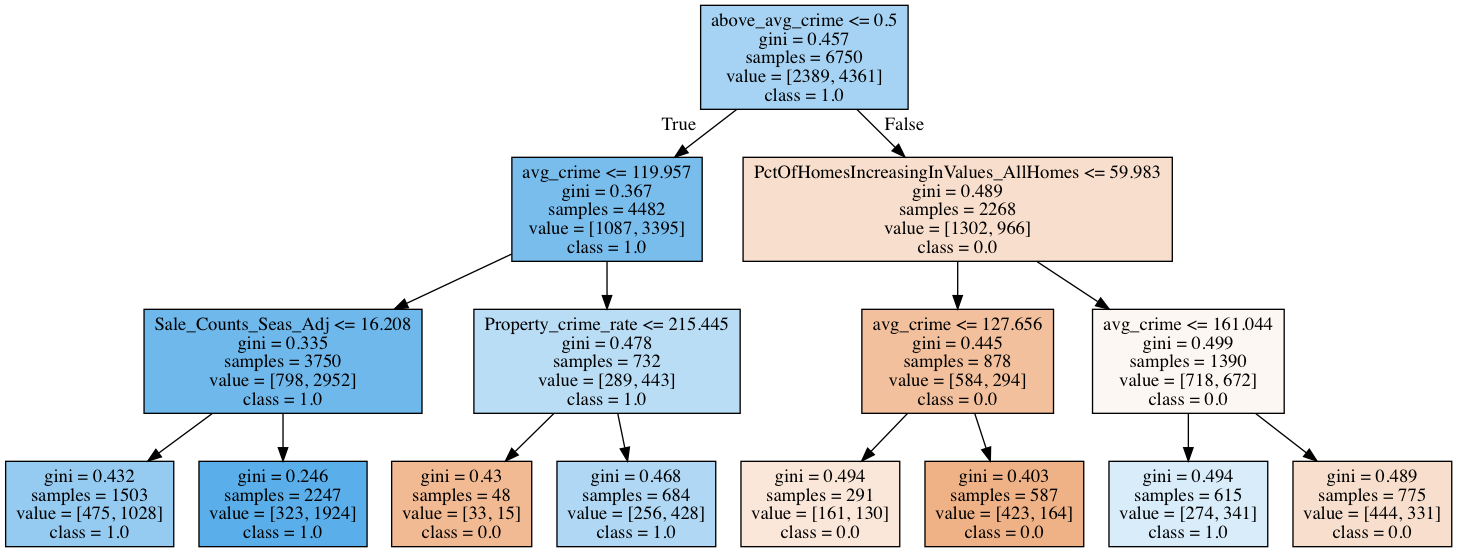

In [129]:
dt = tree.DecisionTreeClassifier(max_depth=3)
dt.fit(X,Y)
dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.string_) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

### Analysis

In general, if a city has a crime rate below the state average, that city will likely have above the state average home values(which is expected). 
However, it is interesting to note when looking at a lower depth on the left, that some cities have high crime rate(above 120 per 10,000) but within that group, if property crime rate is above 215 per 10,000 then the city has high home values where less property crime has low home values.


## Violent vs Property crime analysis based on tree results

Using this information we wanted to see if the type of crime affects home values differently. When starting this project, we expected as any type of crime increased, that home values would decrease.

In [146]:
dftree.drop(['PctOfHomesIncreasingInValues_AllHomes','InventorySeasonallyAdjusted_AllHomes'], axis = 1).describe()

,Population,Violent_crime_rate,Property_crime_rate,ZHVI_AllHomes,above_avg_HV,above_avg_crime,Sale_Counts_Seas_Adj,avg_crime
count,6.750000e+03,6750.000000,6750.000000,6.750000e+03,6750.000000,6750.000000,6750.000000,6750.000000
mean,4.513610e+04,22.740293,203.731701,2.795421e+05,0.646074,0.336000,62.997625,113.235997
std,2.249730e+05,26.691796,154.149739,2.407563e+05,0.478222,0.472374,173.953503,85.803645
min,1.660000e+02,0.000000,0.000000,3.988333e+04,0.000000,0.000000,0.416667,0.000000
25%,7.759000e+03,6.389365,99.064595,1.465312e+05,0.000000,0.000000,12.250000,54.102449
50%,1.636000e+04,13.748854,171.311146,2.192875e+05,1.000000,0.000000,25.166667,94.222141
75%,3.589300e+04,28.913149,266.125656,3.326792e+05,1.000000,1.000000,54.833333,147.756615
max,8.566917e+06,385.515112,2476.351351,4.207875e+06,1.000000,1.000000,3927.833333,1289.434151


From the table above, we describe the following 2 groups:

   Group 1: Cities with property crime below average(less than 200) and violent crime above average (greater than 22)

   Group 2: Cities with property crime above average(greater than 200) and violent crime below average (less than 22)

In [137]:
group1_home_value = dftree[(dfML.Property_crime_rate<200)&(dfML.Violent_crime_rate>22)].ZHVI_AllHomes.mean()
group1_home_value

230586.50688370585

** <font color='blue'>The average home value for cities in group 1 is $230,586 </font></font>**

In [132]:
dftree[(dftree.Property_crime_rate<200)&(dftree.Violent_crime_rate>22)].above_avg_HV.mean()

0.51836734693877551

** <font color='blue'>Only 51.8% of these cities have home values above the state average. </font></font>**

In [138]:
group2_home_value = dftree[(dftree.Property_crime_rate>200)&(dftree.Violent_crime_rate<22)].ZHVI_AllHomes.mean()
group2_home_value

275369.66917110007

** <font color='blue'>The average home value for cities in group 2 is $275,370 </font></font>**

In [143]:
dftree[(dftree.Property_crime_rate>200)&(dftree.Violent_crime_rate<22)].avg_crime.mean()

147.35357567076861

In [140]:
dftree[(dftree.Property_crime_rate>200)&(dftree.Violent_crime_rate<22)].above_avg_HV.mean()

0.6802270577105014

#### <font color='blue'>Group 2 has a total average crime of 147+ per 10,000 population. This puts group 2 puts it in the 75th percentile for crime so it is surprising that 68% of these cities have home values above the state average.</font></font>

### What's the percentage difference between the two groups? 

In [141]:
(group2_home_value-group1_home_value)/group1_home_value

0.19421414935601672


** Home values the cities of group 2 are <font color='red'>over 19% higher </font></font>than home values of cities in group 1. **

Again this may seem counter intuitive that a place with more crime has higher home values. However it seems that violent crime rates have a stronger negative correlation with home values while property crime rates do not seem to have as strong of a correlation with home values. A likely explanation is that while crime can have a negative impact on home values, property crime in particular seems more likely to occur in more affluent neighborhoods. Therefore, the increase in property crime could be a result of higher valued homes.

# Classification and Prediction

In [117]:
from sklearn.model_selection import KFold

In [118]:
nfolds = 10

In [119]:
kf = KFold(n_splits=nfolds, random_state = 0, shuffle = True)

In [120]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

clfs = [DecisionTreeClassifier(), sk.ensemble.RandomForestClassifier(n_jobs=-1), sk.naive_bayes.GaussianNB(),
        sk.linear_model.LogisticRegression(n_jobs=-1),sk.tree.DecisionTreeClassifier(),sk.ensemble.AdaBoostClassifier(),
        QuadraticDiscriminantAnalysis(),MLPClassifier(),SVC()]

In [121]:
maxAUC = -1
bestCL = ""
for cl in clfs:
    auc = sk.model_selection.cross_val_score(cl,X,Y,cv=kf,n_jobs=-1,scoring = 'roc_auc').mean()
    print (str(cl) + ' ' + str(auc))
    if auc > maxAUC:
        bestCL = cl
        maxAUC = auc
print ' '
print ('The best is ' + str(bestCL))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') 0.634690486679
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 0.730875913091
GaussianNB(priors=None) 0.706539130922


/Users/tyleryoung/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/Users/tyleryoung/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/Users/tyleryoung/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/Users/tyleryoung/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 0.762362401938
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') 0.634690486679
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None) 0.747149822119


/Users/tyleryoung/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/tyleryoung/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/tyleryoung/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/tyleryoung/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001) 0.584439708726
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False) 0.747575495961
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 0.611849091391
 
The best is LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-

In [132]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=0)
from sklearn.linear_model import LogisticRegression
cl = LogisticRegression(random_state=0)
cl.fit(X_train,Y_train)
(cl.predict(X_test) == Y_test).mean()

0.73190546528803546

In [133]:
y_pred = cl.predict(X_test)
y_pred_proba = cl.predict_proba(X_test)[:,1]
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test,y_pred)

array([[208, 250],
       [113, 783]])

In [134]:
(y_pred == Y_test).mean()

0.73190546528803546

Precision

In [135]:
import sklearn.metrics as met
met.precision_score(Y_test, y_pred)

0.75798644724104547

In [136]:
Y_test.mean()

0.66174298375184637

Recall

In [138]:
met.recall_score(Y_test, y_pred)

0.8738839285714286

In [137]:
met.roc_auc_score(Y_test, y_pred)

0.66401620009357454

## Clustering

In [108]:
from sklearn.cluster import KMeans

In [109]:
dfclu = dfML.copy()

In [110]:
clu = KMeans(n_clusters=3, random_state=0)

In [111]:
dfclu.drop(['City','Population', 'State','above_avg_crime',
            'Population_bin','avg_crime_bin','Year'], axis = 1, inplace = True)

In [112]:
dfclu.corr()

,Violent_crime_rate,Property_crime_rate,PctOfHomesIncreasingInValues_AllHomes,InventorySeasonallyAdjusted_AllHomes,ZHVI_AllHomes,above_avg_HV,Sale_Counts_Seas_Adj,YoY_homevalue,YoY_crime,avg_crime
Violent_crime_rate,1.000000,0.592325,0.124071,0.223569,-0.229399,-0.355896,0.259633,-0.021420,0.073629,0.689330
Property_crime_rate,0.592325,1.000000,0.148184,0.142369,-0.177173,-0.246515,0.172077,0.007985,0.197368,0.991994
PctOfHomesIncreasingInValues_AllHomes,0.124071,0.148184,1.000000,0.056019,0.074114,0.086719,0.164945,0.274469,0.000165,0.152687
InventorySeasonallyAdjusted_AllHomes,0.223569,0.142369,0.056019,1.000000,-0.003818,0.009918,0.904147,0.010923,-0.006856,0.163053
ZHVI_AllHomes,-0.229399,-0.177173,0.074114,-0.003818,1.000000,0.340087,-0.003544,0.498410,0.034448,-0.195262
above_avg_HV,-0.355896,-0.246515,0.086719,0.009918,0.340087,1.000000,0.011769,0.196672,0.031408,-0.277438
Sale_Counts_Seas_Adj,0.259633,0.172077,0.164945,0.904147,-0.003544,0.011769,1.000000,0.038930,-0.001096,0.195418
YoY_homevalue,-0.021420,0.007985,0.274469,0.010923,0.498410,0.196672,0.038930,1.000000,0.019155,0.003823
YoY_crime,0.073629,0.197368,0.000165,-0.006856,0.034448,0.031408,-0.001096,0.019155,1.000000,0.189005
avg_crime,0.689330,0.991994,0.152687,0.163053,-0.195262,-0.277438,0.195418,0.003823,0.189005,1.000000


In [113]:
clu.fit(dfclu)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [114]:
dfclu2 = dfclu.copy()

In [115]:
dfclu2['cluster']=clu.labels_

In [116]:
dfclu2.groupby('cluster').mean()

,Violent_crime_rate,Property_crime_rate,PctOfHomesIncreasingInValues_AllHomes,InventorySeasonallyAdjusted_AllHomes,ZHVI_AllHomes,above_avg_HV,Sale_Counts_Seas_Adj,YoY_homevalue,YoY_crime,avg_crime
cluster,,,,,,,,,,
0,25.240543,212.903871,64.825581,183.015016,1.964549e+05,0.566124,63.355330,9009.162677,-3.196066,119.072207
1,9.621115,164.629391,68.563075,118.776995,1.627772e+06,1.000000,32.983568,107452.112676,2.588822,87.125253
2,14.094246,151.401913,66.974281,201.804552,5.237627e+05,0.927736,71.941323,27950.141693,-0.604596,82.748079


#### <font color='blue'>Similar to the tree, the clusters show that in general places with higher average crime have lower home values. However cluster 1 has a higher average crime rate than cluster 2 because cluster 1 has a higher property crime rate. But on average the home values for cluster 1 are higher than cluster 2. </font></font>


# Year over year

#### Created shifted home value column and crime rate for grouped by each city. This will be used to create a new column to compare the year over year change in home value and crime rate

shift home values and join to create a new data frame

In [30]:
dfb = df7.groupby(['City', 'State']).apply(lambda x:x.ZHVI_AllHomes.shift(1)).reset_index()

In [31]:
dfb.set_index('level_2',inplace=True)
dfb.index.name=None
dfYoY = df7.join(dfb, how='outer',rsuffix='_y')

In [32]:
dfYoY.drop(['City_y','State_y'], axis = 1, inplace = True)

shift violent crime rate and join to previous dfYoY

In [33]:
dfc = dfYoY.groupby(['City', 'State']).apply(lambda x:x.avg_crime.shift(1)).reset_index()

In [34]:
dfc.set_index('level_2',inplace=True)
dfc.index.name=None
dfYoY = dfYoY.join(dfc, how='outer',rsuffix='_y')

In [35]:
dfYoY.drop(['City_y','State_y'], axis = 1, inplace = True)

In [36]:
dfYoY['YoY_crime'] = dfYoY['avg_crime'] - dfYoY['avg_crime_y']

In [37]:
dfYoY['YoY_homevalue'] = dfYoY['ZHVI_AllHomes'] - dfYoY['ZHVI_AllHomes_y']

## Where to move?

Are there cities that are safe for a family (low crime) and a good investment(crime decreasing so expected to increase in home value)?

In [393]:
dfa = dfYoY[['City','State','Year', 'Population', 
            'ZHVI_AllHomes','above_avg_HV','above_avg_crime',
            'YoY_homevalue','YoY_crime','avg_crime']]

In [395]:
dfa.describe()

,Population,ZHVI_AllHomes,above_avg_HV,above_avg_crime,YoY_homevalue,YoY_crime,avg_crime
count,1.195200e+04,1.195200e+04,11952.000000,11952.000000,11952.000000,11952.000000,11952.000000
mean,2.834666e+04,2.312259e+05,0.501590,0.382530,11417.858329,-3.781436,126.431976
std,1.439550e+05,2.559073e+05,0.500018,0.486025,32222.528533,51.275207,105.162160
min,1.480000e+02,2.980833e+04,0.000000,0.000000,-356366.666667,-2812.510800,0.000000
25%,3.790500e+03,1.144188e+05,0.000000,0.000000,2291.666667,-17.160851,57.109671
50%,8.888000e+03,1.628958e+05,1.000000,0.000000,6883.333333,-2.198531,103.066285
75%,2.377175e+04,2.598083e+05,1.000000,1.000000,14408.333333,10.321230,167.473499
max,8.566917e+06,6.010350e+06,1.000000,1.000000,964658.333333,1433.416573,3008.130081


In [444]:
dfa[(dfa.avg_crime<50)&(dfa.YoY_crime<0)&(dfa.Population>40000)&(dfa.Year =='2016')&(
        dfa.YoY_homevalue>15000)].sort_values(by = 'YoY_homevalue', ascending = False)

,City,State,Year,Population,ZHVI_AllHomes,above_avg_HV,above_avg_crime,YoY_homevalue,YoY_crime,avg_crime
4830,Danville,CA,2016,44897,1.164867e+06,1.0,0.0,65466.666667,-15.329809,41.650890
14051,Newton,MA,2016,89116,9.132833e+05,1.0,0.0,62708.333333,-6.989454,38.601373
598,Arlington,MA,2016,45004,6.233250e+05,1.0,0.0,39158.333333,-17.808132,31.330548
16523,Rancho Santa Margarita,CA,2016,49606,6.029750e+05,1.0,0.0,31808.333333,-3.145925,31.750192
10017,Keller,TX,2016,47047,3.643083e+05,1.0,0.0,29508.333333,-7.751663,31.351627
1754,Billerica,MA,2016,42965,3.831167e+05,1.0,0.0,28025.000000,-7.150372,28.395205
1707,Beverly,MA,2016,41303,3.927750e+05,1.0,0.0,25158.333333,-5.354812,47.817350
16004,Plymouth,MA,2016,59088,3.230750e+05,0.0,0.0,16666.666667,-5.965972,39.771189
2632,Buffalo Grove,IL,2016,41511,2.849083e+05,1.0,0.0,16158.333333,-1.637255,26.619450


Pull data from previous 'dfYoY' for select cities to plot.

In [92]:
dfc = df7[((df7.City=='Danville')&(df7.State=='CA'))|(df7.City=='Rancho Santa Margarita')|((
            df7.City =='Newton')&(df7.State =='MA'))|((df7.City =='Keller')&(dfYoY.State=='TX'))|((
        df7.City =='Arlington')&(df7.State=='MA'))]

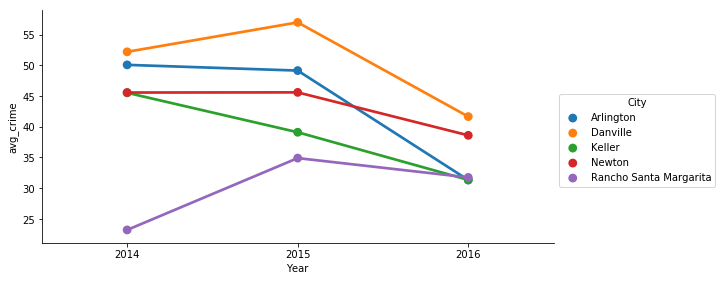

In [94]:
sns.factorplot(x = 'Year', y = 'avg_crime', hue = 'City', data = dfc, kind = 'point', aspect = 2)

In [90]:
dfb = df2[(((df2.City=='Danville')&(df2.State=='CA'))|(df2.City=='Rancho Santa Margarita')|((
            df2.City =='Newton')&(df2.State =='MA'))|((df2.City =='Keller')&(df2.State=='TX'))|((
        df2.City =='Arlington')&(df2.State=='MA')))&(df2.Year>'1999')]

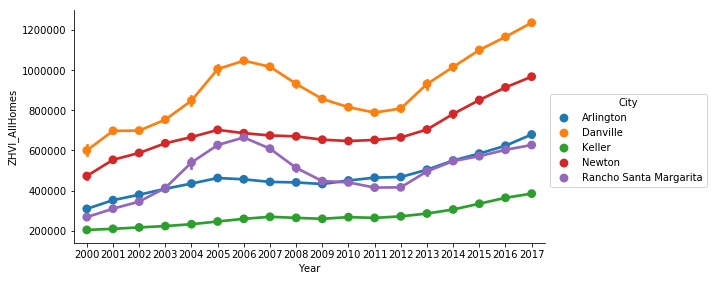

In [91]:
sns.factorplot(x = 'Year', y = 'ZHVI_AllHomes', hue = 'City', data = dfb, kind = 'point', aspect = 2)

### <font color='blue'>Danville CA, Newton MA, Arlington MA, Keller TX, and Rancho Santa Margarita CA, are the top cities in the nation that are increasing in home values while also having among the lowest crime rates. These crime rates are also continuing to decrease year over year, so it would be expected with that trend that home values will continue to rise. That makes these cities prime places to move that are both safe for families and a good investment for the future.</font></font>